In [9]:
import math
import pandas as pd
import random
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

In [10]:
data = pd.read_csv('./data/FinalData.csv')
data.head(5)

,ID,Name,Address,Latitude,Longitude,Opening Hours,Types,Rating,User Ratings Total
0,ChIJ-3wY7lEYQjERrJ9wTeoa-WQ,Blue Summer Hotel,"35 Tôn Thất Đạm, Xuân Hà, Thanh Khê, Đà Nẵng 5...",16.072062,108.201392,"['Monday: Open 24 hours', 'Tuesday: Open 24 ho...","['lodging', 'point_of_interest', 'establishment']",3.9,42.0
1,ChIJ-UBpozMYQjERDV3V1nrXEiM,Vinapha 2 Hotel,"19 Phạm Hồng Thái, Hải Châu 1, Hải Châu, Đà Nẵ...",16.067351,108.221777,['Monday: 12:00\u202fAM\u2009–\u200911:59\u202...,"['lodging', 'point_of_interest', 'establishment']",3.0,93.0
2,ChIJ13MshlIYQjERM4sqFu8lvyA,Ribo Coffee,"05 Thái Thị Bôi, Chính Gián, Thanh Khê, Đà Nẵn...",16.068272,108.201195,['Monday: 6:30\u202fAM\u2009–\u200910:30\u202f...,"['cafe', 'food', 'point_of_interest', 'establi...",4.1,306.0
3,ChIJ14kOf8kZQjERrdrrQPpiZKA,Mì Quảng Thi,"251 Hoàng Diệu, Nam Dương, Hải Châu, Đà Nẵng 5...",16.058546,108.217224,['Monday: 6:00\u202fAM\u2009–\u20091:29\u202fP...,"['restaurant', 'point_of_interest', 'food', 'e...",4.3,308.0
4,ChIJ2aT3UqMXQjER_rVaqCoyyWU,Chùa Linh Ứng,"Vườn Lâm Tỳ Ni, Hoàng Sa, Thọ Quang, Sơn Trà, ...",16.100261,108.277747,"['Monday: Open 24 hours', 'Tuesday: Open 24 ho...","['place_of_worship', 'point_of_interest', 'est...",4.7,1785.0


In [35]:
dataHours = pd.read_csv('./data/opening_hours.csv')
dataHours.head(5)

,ID,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,ChIJ-3wY7lEYQjERrJ9wTeoa-WQ,00:00 AM 11:59 PM,00:00 AM 11:59 PM,00:00 AM 11:59 PM,00:00 AM 11:59 PM,00:00 AM 11:59 PM,00:00 AM 11:59 PM,00:00 AM 11:59 PM
1,ChIJ-UBpozMYQjERDV3V1nrXEiM,12:00 AM 11:59 PM,12:00 AM 11:59 PM,12:00 AM 11:59 PM,12:00 AM 11:59 PM,12:00 AM 11:59 PM,12:00 AM 11:59 PM,12:00 AM 11:59 PM
2,ChIJ13MshlIYQjERM4sqFu8lvyA,6:30 AM 10:30 PM,6:30 AM 10:30 PM,6:30 AM 10:30 PM,6:30 AM 10:30 PM,6:30 AM 10:30 PM,6:30 AM 10:30 PM,6:30 AM 10:30 PM
3,ChIJ14kOf8kZQjERrdrrQPpiZKA,"6:00 AM 1:29 PM, 4:00 9:00 PM","6:00 AM 1:29 PM, 4:00 9:00 PM","6:00 AM 1:29 PM, 4:00 9:00 PM","6:00 AM 1:29 PM, 4:00 9:00 PM","6:00 AM 1:29 PM, 4:00 9:00 PM","6:00 AM 1:29 PM, 4:00 9:00 PM","6:00 AM 1:29 PM, 4:00 9:00 PM"
4,ChIJ2aT3UqMXQjER_rVaqCoyyWU,00:00 AM 11:59 PM,00:00 AM 11:59 PM,00:00 AM 11:59 PM,00:00 AM 11:59 PM,00:00 AM 11:59 PM,00:00 AM 11:59 PM,00:00 AM 11:59 PM


In [11]:
newData = data.loc[:, ["ID", "Name", "Latitude", "Longitude"]]
newData.head(5)

,ID,Name,Latitude,Longitude
0,ChIJ-3wY7lEYQjERrJ9wTeoa-WQ,Blue Summer Hotel,16.072062,108.201392
1,ChIJ-UBpozMYQjERDV3V1nrXEiM,Vinapha 2 Hotel,16.067351,108.221777
2,ChIJ13MshlIYQjERM4sqFu8lvyA,Ribo Coffee,16.068272,108.201195
3,ChIJ14kOf8kZQjERrdrrQPpiZKA,Mì Quảng Thi,16.058546,108.217224
4,ChIJ2aT3UqMXQjER_rVaqCoyyWU,Chùa Linh Ứng,16.100261,108.277747


In [12]:
#Cloudy Phan Dang Luu
latInit = 16.019110655988168
lngInit = 108.22903420822459

In [13]:
def haversineDistance(lat1, lng1, lat2, lng2):
    latRadian1 = math.radians(lat1)
    lngRadian1 = math.radians(lng1)
    latRadian2 = math.radians(lat2)
    lngRadian2 = math.radians(lng2)

    dlat = latRadian2 - latRadian1
    dlng = lngRadian2 - lngRadian1
    R = 6371e3

    a = math.sin(dlat/2) ** 2 + math.cos(latRadian1) * math.cos(latRadian2) * math.sin(dlng/2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c

In [14]:
def calFitness(routeDistance: float):
    return 1/(routeDistance + 1)

In [15]:
class TimeActive:
    def __init__(self, open: int, close: int) -> None:
        self.open = open
        self.close = close

In [52]:
class Location:
    def __init__(self, x: float, y: float, timeOpens: List[TimeActive] = None) -> None:
        self.x = x
        self.y =y
        self.timOpens = timeOpens

    def to_tupl(self) -> Tuple:
        return (self.x, self.y)

In [109]:
class Route:
    def __init__(self, route: List['Location']) -> None:
        self.route = route
        self.distance: float = 0.0
        self.fitness: float = 0.0
    
    def routeDistance(self) -> float:
        if self.distance == 0: 
            pathDistance = 0.0  
            for index in range(0, len(self.route) - 1):
                dist = haversineDistance(self.route[index].x, self.route[index].y, self.route[index + 1].x, self.route[index + 1].y)
                pathDistance+= dist
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self) -> float:
        if self.fitness == 0:
            self.fitness = calFitness(self.routeDistance())
        return self.fitness
    
    def coordinates(self) -> Tuple[List[float], List[float]]:
        x_list, y_list = [], []
        for location in self.route:
            x_list.append(location.to_tupl()[0])
            y_list.append(location.to_tupl()[1])
        return x_list, y_list

In [54]:
def compareTime(currentTime, stayTime, timeOpens: List[TimeActive]):
    for i in range(len(timeOpens)):
        #lon hon thoi gian mo cua, thoi gian roi di be hon thoi gian dong cua
        if timeOpens[i].open <= currentTime and timeOpens[i].close >= currentTime + stayTime:
            return True
    return False

In [41]:
import datetime
def handle_duration_and_weekdays(start_time, end_time):
    # Chuyển đổi chuỗi thời gian thành đối tượng datetime
    start_dt = datetime.datetime.strptime(start_time, '%I:%M %p %d/%m/%Y')
    end_dt = datetime.datetime.strptime(end_time, '%I:%M %p %d/%m/%Y')

    # Tính khoảng thời gian và số ngày của nó
    duration_time = int((end_dt - start_dt).total_seconds() // 60)
    num_days = int((end_dt - start_dt).days)

    # Tạo một mảng các thứ trong khoảng thời gian
    current_dt = start_dt
    weekdays = []
    while current_dt <= end_dt:
        weekdays.append(current_dt.strftime('%A'))
        current_dt += datetime.timedelta(days=1)

    return duration_time, num_days, weekdays

print(handle_duration_and_weekdays("7:00 AM 19/4/2023", "7:00 AM 21/4/2023"))

(2880, 2, ['Wednesday', 'Thursday', 'Friday'])


In [34]:
def handleTimes(time, text):
    time = time.split(':')

    hour = int(time[0])
    minute = int(time[1])

    value = hour * 60 + minute if text == 'AM' else (hour+ 12) * 60 + minute
    return value

In [49]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdays_opening_hours = {}
for day in range(len(days)):
    timeOpens = []
    for i in range(0, len(dataHours)):
        openingHours = dataHours.iloc[i][days[day]]
        openingHours = openingHours.strip("']['").split(',')
        opens = []
        closes = []
        for item in openingHours:
            times = item.strip(' ').split(' ')
            timeOpen = handleTimes(times[0], times[1])
            timeClose = handleTimes(times[-2], times[-1])
            opens.append(timeOpen)
            closes.append(timeClose)
        timeOpens.append([TimeActive(opens[i], closes[i]) for i in range(len(opens))])
    weekdays_opening_hours[days[day]] = timeOpens
print(weekdays_opening_hours)

{'Monday': [[<__main__.TimeActive object at 0x000001FA51315760>], [<__main__.TimeActive object at 0x000001FA513153D0>], [<__main__.TimeActive object at 0x000001FA513158E0>], [<__main__.TimeActive object at 0x000001FA51315520>, <__main__.TimeActive object at 0x000001FA51315220>], [<__main__.TimeActive object at 0x000001FA51315850>], [<__main__.TimeActive object at 0x000001FA51315040>], [<__main__.TimeActive object at 0x000001FA51315F10>], [<__main__.TimeActive object at 0x000001FA51315430>], [<__main__.TimeActive object at 0x000001FA51315400>], [<__main__.TimeActive object at 0x000001FA51315A30>], [<__main__.TimeActive object at 0x000001FA51315AC0>], [<__main__.TimeActive object at 0x000001FA51315610>], [<__main__.TimeActive object at 0x000001FA513152E0>], [<__main__.TimeActive object at 0x000001FA51315130>], [<__main__.TimeActive object at 0x000001FA511BF490>], [<__main__.TimeActive object at 0x000001FA511BFAC0>], [<__main__.TimeActive object at 0x000001FA511BF880>], [<__main__.TimeAct

In [104]:
def getPointByDay(data, startPoint, startTime, stayTime, day, allPoints):
    timeOpens = weekdays_opening_hours[day]
    currentPoint = startPoint
    timeCome = startTime
    listDetailPoints = [{'location': Location(currentPoint[0], currentPoint[1]),'time': (timeCome, timeCome), 'timeOpens': 'Start point'}]
    listPoints = [currentPoint]
    while(timeCome + stayTime < 1350):
        minDistance = float('inf')
        nextPoint = None
        point = None
        timeCome = timeCome + 30
        name = None

        for i, row in data.iterrows():
            lat = row['Latitude']
            lng = row['Longitude']
            timeOpen = timeOpens[i]
            
            if (lat, lng) not in listPoints and (lat, lng) not in allPoints:
                if compareTime(timeCome, stayTime, timeOpen) == False:
                    continue

                dist = haversineDistance(currentPoint[0], currentPoint[1], lat, lng)

                if dist < minDistance:
                    minDistance = dist
                    nextPoint = (lat, lng)
                    point = i
                    name = row['Name']
    
        if nextPoint is not None:
            currentPoint = nextPoint
            listPoints.append(currentPoint)
            listDetailPoints.append({'name': name, 'location': Location(currentPoint[0], currentPoint[1], timeOpens[point]),'time': (timeCome, timeCome + stayTime)})
            timeCome = timeCome + stayTime
    listDetailPoints.append({'location': Location(currentPoint[0], currentPoint[1]),'time': (timeCome, timeCome), 'timeOpens': 'End point'})
    return listPoints, listDetailPoints

In [122]:
def nearestNeighborAlgorithm(data):
    duration_time, num_days, weekdays = handle_duration_and_weekdays("7:00 AM 19/4/2023", "7:00 AM 23/4/2023")
    startPoint = (latInit, lngInit)
    allPoints = []
    routesInfo = []

    for day in range(num_days):
        startTime = handleTimes("07:00", "AM") 
        ####### find in day
        listPoints, listDetailPoints = getPointByDay(data, startPoint, startTime, 90, weekdays[day], allPoints)
        allPoints += listPoints
        routesInfo.append(listDetailPoints)

    return routesInfo

In [64]:
def nearestNeighborAlgorithm1(data, n = 14):
    startPoint = (latInit, lngInit)
    listPoints = []
    listDetailsPoint = []

    currentPoint = startPoint
    listPoints.append(currentPoint)
    detailsPoint = [ 0, 'Cloudy', currentPoint]
    listDetailsPoint.append(detailsPoint)

    while(len(listPoints) < n):
        minDistance = float('inf')
        nextPoint = None
        name = None
        index = 0

        for i , row in data.iterrows():
            
            lat = row['Latitude']
            lng = row['Longitude']
            if(lat, lng) not in listPoints:
                dist = haversineDistance(currentPoint[0], currentPoint[1], lat, lng)
                
                if dist < minDistance:
                    minDistance = dist
                    nextPoint = (lat, lng)
                    name = row['Name']
                    index = i + 1
            
        if nextPoint is not None:
            currentPoint = nextPoint
            listPoints.append(currentPoint)
            detailsNewPoint = [index, name, currentPoint]
            listDetailsPoint.append(detailsNewPoint)

    endPoint = startPoint
    listPoints.append(endPoint)
    listDetailsPoint.append(detailsPoint)

    return listPoints, listDetailsPoint

In [106]:
def initPopulation1(populationSize: int, listInitLocations: List = None) -> List[List['Location']]:
    population = []

    listSamples = list(range(1, len(listInitLocations) - 1))

    for _ in range(populationSize):
        if listInitLocations is not None:
            listRandoms = random.sample(listSamples, len(listSamples))
            newLocation = [listInitLocations[0]] + [listInitLocations[i] for i in listRandoms] + [listInitLocations[-1]]

            population.append(newLocation)

    return population

In [113]:
def updateArrivalTime(locations):
    startTime = handleTimes("07:00", "AM")
    timeCome = startTime 
    stayTime = 90
    for i in range(1, len(locations)):
        timeCome += 30
        locations[i]['time'] = (timeCome, timeCome + stayTime)
    return locations

In [120]:
def initPopulation(populationSize: int, listInitLocations: List = None) -> List[List['Location']]:
    population = []

    listSamples = list(range(1, len(listInitLocations) - 1))

    while(len(population) < populationSize):
        if listInitLocations is not None:
            listRandoms = random.sample(listSamples, len(listSamples))
            newLocation = [listInitLocations[0]] + [listInitLocations[i] for i in listRandoms] + [listInitLocations[-1]]
            
            population.append(updateArrivalTime(newLocation))

    return population

In [123]:
def rankRoutes(population: List[List['Location']]) -> List[Tuple[int, float]]:
    fitnessResults: Dict = {}

    for i in range(len(population)):
        popItem: List[Location] = [pop['location'] for pop in population[i]]
        fitnessResults[i] = Route(popItem).routeFitness()

    return sorted(fitnessResults.items(), key=lambda x: x[1], reverse=True)

In [111]:
def touramentSelection(populationRanked: List[Tuple[int, float]], numElites: int = 0):
    df = pd.DataFrame(np.array(populationRanked), columns=["Index", "Fitness"])
    df["weights"] = 100 * df.Fitness / df.Fitness.sum()
    selection_results = df.sample(n=len(populationRanked)-numElites,
                                  replace=True,
                                  weights=df.weights
                                  ).values[:, 0]
    elite_results = df.iloc[0:numElites, 0].values
    selection_results = list(map(int, np.concatenate(
        (selection_results, elite_results)).tolist()))
    return selection_results

In [112]:
def mergedPoint(population: List[List['Location']], selection_results: List[int]) -> List[List['Location']]:
    output: List = []
    for i in range(len(selection_results)):
        index = selection_results[i]
        output.append(population[index])
    return output

In [116]:
def crossoverMix(parent1: List['Location'], parent2: List['Location']):
    point1, point2 = random.sample(range(1, len(parent1)-1), 2)
    begin = min(point1, point2)
    end = max(point1, point2)

    child1_begin = parent1[:begin]
    child1_end = parent1[end:]

    child1 = child1_begin + child1_end
    child2 = parent2[begin:end+1]

    child1_remain = [item for item in parent2[1:-1] if item not in child1]
    child2_remain = [item for item in parent1[1:-1] if item not in child2]

    child1 = child1_begin + child1_remain + child1_end
    child2 += child2_remain

    child2.insert(0, parent2[0])
    child2.append(parent2[0])

    child1 = updateArrivalTime(child1)
    child2 = updateArrivalTime(child2)

    return child1, child2

In [117]:
def crossoverPopulation(mergedPoint: List[List['Location']], numElites: int = 0):
    children: List = []
    numNonElite = len(mergedPoint) - numElites

    individuals = random.sample(mergedPoint, len(mergedPoint))

    for i in range(1, numElites + 1):
        children.append(mergedPoint[-i])

    for i in range(0, numNonElite):
        child1, child2 = crossoverMix(individuals[i], individuals[len(mergedPoint) -i -1])
        child1 = updateArrivalTime(child1)
        children.append(child1)

    return children

In [118]:
def mutation(individual: List['Location'], mutationRate):
    if random.random() < mutationRate:
        mutation_index_1, mutation_index_2 = random.sample(range(1, len(individual) - 1), 2)
        begin = min(mutation_index_1, mutation_index_2)
        end = max(mutation_index_1, mutation_index_2)

        individual_begin = individual[:begin]
        individual_end = individual[end+1:]

        individual_center = individual[begin:end+1]
        individual_center.reverse()
        
        individual = individual_begin + individual_center + individual_end

        individual = updateArrivalTime(individual)

    return individual

In [27]:
def mutatePopulation(children: List[List['Location']], mutationRate: float = 0):
    mutatedPopulation: List = []

    for individual in range(0, len(children)):
        mutatedIndividual = mutation(children[individual], mutationRate)
        mutatedPopulation.append(mutatedIndividual)
    return mutatedPopulation

In [119]:
def nextGeneration(currentGen: List[List['Location']], numElites: int, mutationRate: float = 0):
    populationRanked = rankRoutes(currentGen)

    bestCurrentGenRoute = Route(currentGen[populationRanked[0][0]])
    bestCurrentGenFitness = bestCurrentGenRoute.routeFitness()
    bestCurrentGenDistance = bestCurrentGenRoute.routeDistance()

    selectionResults = touramentSelection(populationRanked, numElites)
    individuals = mergedPoint(currentGen, selectionResults)
    children = crossoverPopulation(individuals, numElites)
    nextGeneration = mutatePopulation(children)

    return nextGeneration, bestCurrentGenRoute, bestCurrentGenFitness, bestCurrentGenDistance

In [121]:
def geneticAlgorithm(populationSize: int = 1, numElites: int = 0, numGens: int = 0, mutationRate: float = 0.001, listInitLocations: List = None):
    population = initPopulation(populationSize, listInitLocations)
    bestInitialRoute = Route(population[rankRoutes(population)[0][0]])
    # print("Initial Distance: " + str(bestInitialRoute.routeDistance()))

    bestRouteByGen: List = []
    bestFitnessByGen: List = []
    bestDistanceByGen: List = []

    for _ in range(0, numGens):
        population, bestCurrentGenRoute, bestCurrentGenFitness, bestCurrentGenDistance = \
            nextGeneration(population, numElites, mutationRate)
        
        bestRouteByGen.append(bestCurrentGenRoute)
        bestFitnessByGen.append(bestCurrentGenFitness)
        bestDistanceByGen.append(bestCurrentGenDistance)

    bestFinalRoute = Route(population[rankRoutes(population)[0][0]])
    # print("Final Distance: " + str(bestFinalRoute.routeDistance()))

    params = [populationSize,  numElites, numGens, mutationRate, listInitLocations]
    return bestFinalRoute, bestInitialRoute, bestFitnessByGen, bestDistanceByGen, params

In [126]:
def check():
    initLocations = nearestNeighborAlgorithm(newData)
    print(initLocations)
    for i in initLocations:
        bfr, brbg, bfbg, bdbg, params = geneticAlgorithm(3000, 500, 50, 0.005, i)
check()

[[{'location': <__main__.Location object at 0x000001FA517F2340>, 'time': (420, 420), 'timeOpens': 'Start point'}, {'name': 'Brown Bean Hotel', 'location': <__main__.Location object at 0x000001FA517F2B50>, 'time': (450, 540)}, {'name': "Children's cultural houses", 'location': <__main__.Location object at 0x000001FA517F2490>, 'time': (570, 660)}, {'name': 'Đài Tưởng niệm Liệt sỹ TP Đà Nẵng', 'location': <__main__.Location object at 0x000001FA517F2640>, 'time': (690, 780)}, {'name': 'Quảng trường 2/9', 'location': <__main__.Location object at 0x000001FA517F29A0>, 'time': (810, 900)}, {'name': 'Minh Toan Galaxy Hotel', 'location': <__main__.Location object at 0x000001FA517F2580>, 'time': (930, 1020)}, {'name': 'Que Xua Restaurant', 'location': <__main__.Location object at 0x000001FA517F24F0>, 'time': (1050, 1140)}, {'name': 'Chân Cầu Trần Thị Lý 1', 'location': <__main__.Location object at 0x000001FA517F2850>, 'time': (1170, 1260)}, {'location': <__main__.Location object at 0x000001FA517F

AttributeError: 'dict' object has no attribute 'x'

In [30]:
listInitialPoints = []
for i in range(50):
    listRandoms = newData.sample(14)
    listPoints = []
    for i , row in listRandoms.iterrows():    
        lat = row['Latitude']
        lng = row['Longitude']
        listPoints.append((lat, lng))
    listInitialPoints .append(listPoints)
listInitialPoints

[[(16.0763229, 108.221648),
  (16.0633901, 108.2197091),
  (16.0612036, 108.2177017),
  (16.0492669, 108.207966),
  (16.0553013, 108.2086607),
  (16.0623347, 108.2196561),
  (16.074429, 108.2235242),
  (16.1232445, 108.219924),
  (16.068191, 108.223502),
  (16.0632781, 108.1828231),
  (16.0706791, 108.2153696),
  (16.0487675, 108.2132138),
  (16.0481312, 108.2093638),
  (16.0401447, 108.2139202)],
 [(16.0954282, 108.2431088),
  (16.0672541, 108.2245584),
  (16.062526, 108.2101802),
  (16.0515234, 108.2114104),
  (16.065005, 108.2001655),
  (16.067859, 108.2173772),
  (16.0546774, 108.1716124),
  (16.0481312, 108.2093638),
  (16.0611087, 108.2274955),
  (16.0483415, 108.2267041),
  (16.0667959, 108.2246663),
  (16.0359504, 108.2242925),
  (16.0632799, 108.2296041),
  (16.0510826, 108.2290629)],
 [(16.074429, 108.2235242),
  (16.0667352, 108.2246568),
  (16.1147325, 108.2572469),
  (15.9567747, 107.9911844),
  (16.0359504, 108.2242925),
  (16.2, 108.133333),
  (16.0680564, 108.2143082),


In [21]:
listInitalLocations: List[List[Location]] = []
for listPoint in listInitialPoints:
    listInitalLocation = [Location(i[0], i[1]) for i in listPoint]
    listInitalLocations.append(listInitalLocation)

In [ ]:
listFitness = []
for i in listInitalLocations:
    bfr, brbg, bfbg, bdbg, params = geneticAlgorithm(3000, 500, 50, 0.005, i)
    listFitness.append(bfr.routeFitness())


In [23]:
bestDistanceByMutation = []
mutations = []
numPops = []
numGens = []
numElites = []

In [24]:
numPop = [1000, 1500, 2000, 2500, 3000]
numElite = [400, 500]
numGen = [50, 100]

In [25]:
store = bestDistanceByMutation

In [ ]:
bestDistanceByMutation = []
i = 0.001
while(i <= 0.3):
    bfr, brbg, bfbg, bdbg, params = geneticAlgorithm(3000, 500, 50, i, listInitalLocations)
    bestDistanceByMutation.append(bfr.routeDistance())
    i += 0.001

In [23]:
{'mutationRate': 0.005,
 'numElites': 250,
 'numGens': 100,
 'populationSize': 500}

{'mutationRate': 0.005,
 'numElites': 250,
 'numGens': 100,
 'populationSize': 500}

7679.562591733709


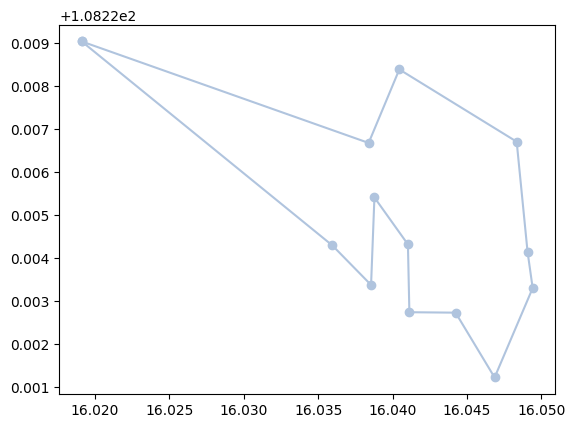

In [24]:
def test():
    listPoints, listDetailsPoint = nearestNeighborAlgorithm(newData, 13)
    listLocations = [Location(i[0], i[1]) for i in listPoints]
    bfr, brbg, bfbg, bdbg, params = geneticAlgorithm(500, 250, 100, 0.005, listLocations)
    print(bfr.routeDistance())
    x, y = bfr.coordinates()
    plt.plot(x, y, **{'color': 'lightsteelblue', 'marker': 'o'})
    plt.show()
test()

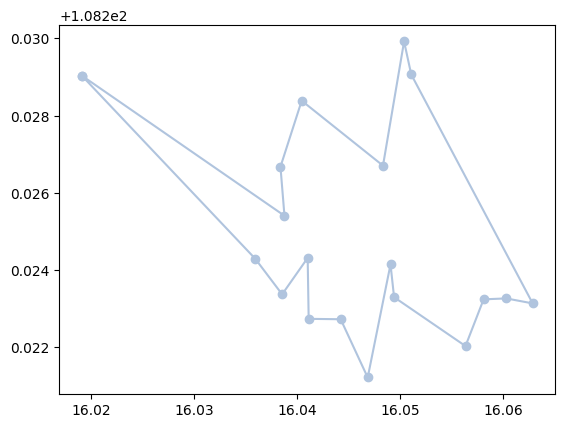

In [29]:
x, y = bfr.coordinates()
plt.plot(x, y, **{'color': 'lightsteelblue', 'marker': 'o'})
plt.show()

In [283]:
def distancePlot(bestDistanceByGen: List[int], params: List):
    plt.plot(bestDistanceByGen)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    s = "popSize: " + str(params[0]) + "\nnumCities: " + str(params[1]) + \
        "\nnumGens: " + str(params[3]) + "\nmutationRate: " + str(params[4])
    # plt.text(s)
    # plt.text(0, bestDistanceByGen[0], round(bestDistanceByGen[0],1))
    plt.text(len(bestDistanceByGen),
             bestDistanceByGen[-1], round(bestDistanceByGen[-1],1))
    plt.show()

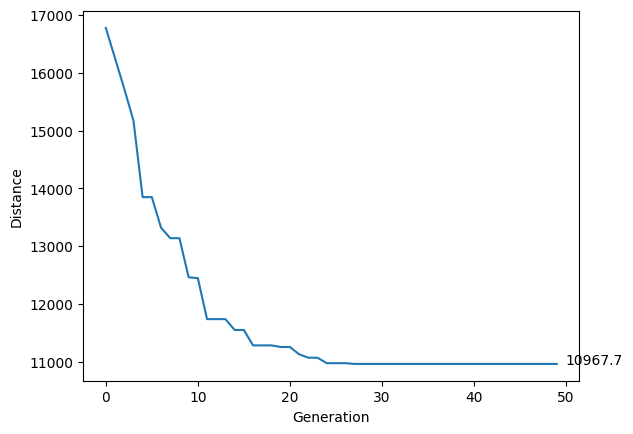

In [31]:
distancePlot(bdbg, params)

In [32]:
def fitnessePlot(bestDistanceByFitness: List[int], xAxis: List[int], params: List):
    plt.plot(xAxis, bestDistanceByFitness)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    s = "popSize: " + str(params[0]) + "\nnumCities: " + str(params[1]) + \
        "\nnumGens: " + str(params[3]) + "\nmutationRate: " + str(params[4])
    # plt.text(s)
    # plt.text(0, bestDistanceByFitness[0], round(bestDistanceByFitness[0],1))
    # plt.text(len(bestDistanceByFitness),
            #  bestDistanceByFitness[-1], round(bestDistanceByFitness[-1],1))
    plt.show()

In [ ]:
i = 0.001
xAxis = []
while(i <= 0.3):
    xAxis.append(i)
    i += 0.001
print(len(bestDistanceByMutation))
print(len(xAxis))
fitnessePlot(bestDistanceByMutation, xAxis, params)

100
100


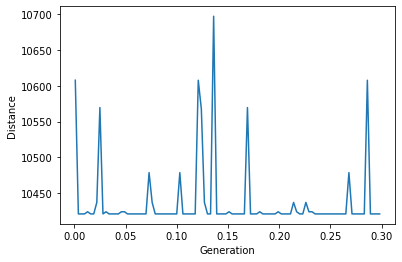

In [51]:
i = 0.001
xAxis = []
while(i <= 0.3):
    xAxis.append(i)
    i += 0.003
print(len(bestDistanceByMutation))
print(len(xAxis))
fitnessePlot(bestDistanceByMutation, xAxis, params)

100
100


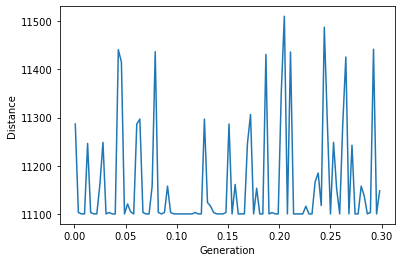

In [57]:
i = 0.001
xAxis = []
while(i <= 0.3):
    xAxis.append(i)
    i += 0.003
print(len(bestDistanceByMutation))
print(len(xAxis))
fitnessePlot(bestDistanceByMutation, xAxis, params)

In [92]:
trainingData = []
for i in range(500):
    listRandoms = newData.sample(22)
    listPoints = []
    for i , row in listRandoms.iterrows():    
        lat = row['Latitude']
        lng = row['Longitude']
        listPoints.append((lat, lng))
    trainingData.append(listPoints)
trainingData[0]

[(16.0954282, 108.2431088),
 (16.0359504, 108.2242925),
 (16.0633724, 108.2215429),
 (16.0667352, 108.2246568),
 (16.0401447, 108.2139202),
 (16.0503829, 108.2150664),
 (16.0481312, 108.2093638),
 (16.0666864, 108.2232191),
 (15.9900211, 108.1404581),
 (16.0673508, 108.2217765),
 (16.0436901, 108.2173205),
 (16.0388189, 108.2448648),
 (16.0660526, 108.2194068),
 (16.0605774, 108.2185875),
 (16.0603007, 108.2232677),
 (16.06291, 108.229815),
 (16.0607217, 108.2200138),
 (16.0672681, 108.2201214),
 (16.0597734, 108.2463747),
 (16.0588475, 108.2181053),
 (16.0629635, 108.218955),
 (16.066815, 108.216984)]

In [62]:
df1 = pd.DataFrame({'location': listInitalLocations, 'fitness': listFitness})
df

,numPops,numGens,numElites,muations,bestDistanceByMutation,fitness
0,1000,50,400,0.001,8360.936516,0.00012
1,1000,50,400,0.004,8360.936516,0.00012
2,1000,50,400,0.007,8360.936516,0.00012
3,1000,50,400,0.010,8360.936516,0.00012
4,1000,50,400,0.013,8363.922600,0.00012
...,...,...,...,...,...,...
2001,3000,100,500,0.286,8360.936516,0.00012
2002,3000,100,500,0.289,8360.936516,0.00012
2003,3000,100,500,0.292,8360.936516,0.00012
2004,3000,100,500,0.295,8360.936516,0.00012


In [26]:
def genetic(mutationRate, populationSize, numElites,numGens, listInitLocations):
    bfr, brbg, bfbg, bdbg, params =geneticAlgorithm(mutationRate=mutationRate, populationSize=populationSize, numElites=numElites,numGens=numGens, listInitLocations=listInitLocations)
    return bfr

In [24]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class ConstantRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, c=None):
        self.c = c
        
    def fit(self, X, y):
        # X, y = check_X_y(X, y)
        if self.c is None:
            self.const_ = y.mean()
        else:
            self.const_ = self.c
        return self
    
    def predict(self, X):
        # check_is_fitted(self)
        # X = check_array(X)
        print(np.array(X.shape[0]*[self.const_]).shape)
        return np.array(X.shape[0]*[self.const_])

In [268]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)
grid = GridSearchCV(
    estimator=ConstantRegressor(),
    param_grid={
        'c': np.linspace(0, 50, 100)
    },
)
fit = grid.fit(X, y)
fit.best_params_

(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)
(4128,)


{'c': 2.0202020202020203}

In [25]:
from sklearn.base import BaseEstimator, RegressorMixin

class GeneticAlgorithmRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, mutationRate: float =0.0, populationSize: int =1, numElites: int=0, numGens: int=0): 
        self.mutationRate = mutationRate
        self.populationSize = populationSize
        self.numElites = numElites
        self.numGens = numGens
        self.ga = None
        self.best_fitness_ = None

    def fit(self, X, y): 
        route = genetic(mutationRate=self.mutationRate, populationSize=self.populationSize, numElites=self.numElites,numGens=self.numGens, listInitLocations=listInitalLocations[0])
        if self.best_fitness_ is None:
            self.best_fitness_ = route.routeFitness()
        if self.best_fitness_ < route.routeFitness():
            self.best_fitness_ = route.routeFitness()
        return self.best_fitness_

    def predict(self, X):
        check_is_fitted(self)
        return np.array(X.shape[0]*[self.best_fitness_])

In [233]:
print(genetic(mutationRate=0.001, populationSize=20, numElites=20,numGens=50, listInitLocations=X[0]))

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Load the TSP dataset

# Set up the genetic algorithm with a fixed crossover rate of 0.8
ga = GeneticAlgorithmRegressor()

# Define the parameter grid for mutation rate
param_grid = {
    'mutationRate': [0.001, 0.005,  0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3],
    'populationSize': [100, 200, 300, 400, 500],
    'numElites': [50, 100, 150, 250],
    'numGens': [ 50, 100],
}

# Set up the grid search
grid_search = GridSearchCV(ga, param_grid, cv=5)
X = listInitalLocations
y = listFitness

# Fit the grid search to the dataset
grid_search.fit(np.array(X),np.array(y))
grid_search.best_params_


/home/gracie/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
330 fits failed out of a total of 2200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
330 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gracie/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/tmp/ipykernel_30953/3895023172.py", line 13, in fit
    route = genetic(mutationRate=self.mutationRate, populationSize=self.populationSize, numElites=self.numElites,numGens=self.numGens, listInitLocations=listInitalLocations[0])
  File "/tmp/ipykernel_30953/2237952851.py", line 2, in 

{'mutationRate': 0.25, 'numElites': 100, 'numGens': 100, 'populationSize': 400}